In [3]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [4]:
import matplotlib.pyplot as plt

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)  # width, height in inches

# Set default font sizes
plt.rcParams['font.size'] = 10  # Default font size
plt.rcParams['axes.titlesize'] = 10  # Title font size
plt.rcParams['axes.labelsize'] = 10  # Label font size
plt.rcParams['xtick.labelsize'] = 10  # x-axis tick label font size
plt.rcParams['ytick.labelsize'] = 10  # y-axis tick label font size
plt.rcParams['legend.fontsize'] = 10  # Legend font size
mpl.rcParams['image.cmap'] = 'viridis'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [5]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [6]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_continuous_vs_discrete'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


/mnt/home/szheng/ceph/place_variability/fig/paper/figure_continuous_vs_discrete
/mnt/home/szheng/ceph/place_variability/data/paper


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [7]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [8]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

# pf_params_all = prepped_data_agg['pf_params_all']
# all_fields_all = prepped_data_agg['all_fields_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



In [9]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [10]:
# add si to all_sw
si_l = []
for i,row in all_sw_with_metrics_d_all.iterrows():
    si_l.append(per_field_metrics_all.loc[(i[0],i[1],i[2],row['trialtype'],row['uid']),:]['si'].mean())
si_l = np.array(si_l)
all_sw_with_metrics_d_all['si'] = si_l

/tmp/ipykernel_2487957/2076179227.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  si_l.append(per_field_metrics_all.loc[(i[0],i[1],i[2],row['trialtype'],row['uid']),:]['si'].mean())


In [11]:
import step_vs_gradual_analysis as svga
reload(svga)

<module 'step_vs_gradual_analysis' from '/mnt/home/szheng/projects/place_variability/code/step_vs_gradual_analysis.py'>

# select examples

In [9]:
subdb

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
e13_26m1    1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e13_16f1    7  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e13_26m1    2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e16_3m2     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e16_3m1     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e16_3m2     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e13_26m1    3  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e16_3m1     2  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e13_16f1    8  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e16_3m1     1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e13_16f1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e15_10m1    5  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
e13_16f1    2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e15_10m1    6  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
e14_2m2     2  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
e15_9f1     4  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e13_16f1    5  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            6  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e15_10m1    3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
e14_2m2     1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
e16_1f1     9  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e15_9f1     3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e16_1f1     5  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     4  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            5  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            7  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            6  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
e16_1f1     4  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e15_9f1     5  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e16_1f1     6  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e15_9f1     2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e16_2m1     2  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e15_10m1    4  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
e15_9f1     0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e14_2m3     3  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
e13_26m1    1  e13_26m1_211019      e13_26m1  2021-10-19   
e13_16f1    7  e13_16f1_210328      e13_16f1  2021-03-28   
e13_26m1    2  e13_26m1_211116      e13_26m1  2021-11-16   
e16_3m2     3   e16_3m2_211213       e16_3m2  2021-12-13   
            2   e16_3m2_211212       e16_3m2  2021-12-12   
e16_3m1     3   e16_3m1_210203       e16_3m1  2021-02-03   
e16_3m

In [12]:
ani = 'e15_13f1'
sess = 'e15_13f1_220117'
ta=0
all_sw_with_metrics_one=all_sw_with_metrics_d_all.loc[ani,sess,ta]
per_field_metrics_one = per_field_metrics_all.loc[ani,sess,ta]
best_n_one = best_n_all_test.loc[ani,sess,ta]

/tmp/ipykernel_2487957/1731020211.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics_one=all_sw_with_metrics_d_all.loc[ani,sess,ta]
/tmp/ipykernel_2487957/1731020211.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[ani,sess,ta]
/tmp/ipykernel_2487957/1731020211.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_n_one = best_n_all_test.loc[ani,sess,ta]


In [16]:
dosave = False
all_fields_recombined = all_fields_recombined_all.loc[ani,sess]


fr_map_trial_df=fr_map_trial_df_all.loc[(ani,sess),:].dropna(axis=1,how='all')
X_raw = X_raw_all.loc[(ani,sess),:]
X_pwc=X_pwc_all.loc[(ani,sess),:]
all_sw_d=all_sw_d_all.loc[(ani,sess),:]
trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df_all.loc[(ani,sess),:])

/tmp/ipykernel_2487957/781901521.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_recombined = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_2487957/781901521.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df=fr_map_trial_df_all.loc[(ani,sess),:].dropna(axis=1,how='all')
/tmp/ipykernel_2487957/781901521.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[(ani,sess),:]
/tmp/ipykernel_2487957/781901521.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc=X_pwc_all.loc[(ani,sess),:]
/tmp/ipykernel_2487957/781901521.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d=all_sw_d_all.loc[(ani,sess),:]
/tmp/ipykernel_2487957/781901521.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  trial_index_to_index_within_df = dpp.trial_index_to_index_within_tria

In [ ]:
# selection: si > 0.5, randomly drawn 

In [30]:
%matplotlib 
np.random.seed(11)

fig,axs_all=plt.subplots(5,8,figsize=(8*2,5*2))
n_samp = int(axs_all.shape[0] * axs_all.shape[1] / 2)

si_thresh = 0.5
field_ma = (best_n_one > 0) & (per_field_metrics_one['si']>si_thresh)
field_sub = field_ma.loc[field_ma].sample(n_samp).index

tt_uid_field_id_order_l = [(*k,best_n_one.loc[k]) for k in field_sub]

for ii,(tt,uid,field_id,order) in enumerate(tt_uid_field_id_order_l):
    axs = axs_all.ravel()[ii*2:ii*2+2]
    fig,axs=svga.fit_plot_step_vs_continuous_example(fr_map_trial_df,
                                            X_raw,X_pwc,all_sw_d,trial_index_to_index_within_df,
                                            all_fields_recombined,
                                            best_n_one,
                                            ncpts=order,ii=None,
                                            ta=ta,tt=tt,min_size=2,
                                                uid=uid,field_id=field_id,
                                                     dosave=dosave,
                                                     figdir=figdir,
                                                     sess=sess,
                                                     figsize=(4,3),
                                                     do_legend=False,
                                                     fig=fig,
                                                     axs=axs
                                           )
    
#     axs[0].legend([]).remove()


plt.tight_layout()
figfn = 'supp_more_examples'
ph.save_given_name(fig,figfn,figdir)

Using matplotlib backend: agg


/mnt/home/szheng/projects/util_code/plot_helper.py:626: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/mnt/home/szheng/projects/util_code/plot_helper.py:626: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/mnt/home/szheng/projects/place_variability/code/step_vs_gradual_analysis.py:135: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/mnt/home/szheng/projects/util_code/plot_helper.py:626: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/mnt/home/szheng/projects/place_variability/code/step_vs_gradual_analysis.py:135: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/mnt/home/szheng/projects/util_code/plot_helper.py:626: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x

In [35]:
all_sw_with_metrics_one.query('trialtype==0&uid==206&field_index==0')

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,...,post_ntrial_le_30_perc_frac_total,post_ntrial_le_50_perc_frac_total,post_ntrial_le_70_perc_frac_total,post_ntrial_le_90_perc_frac_total,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total,si


In [33]:
tt_uid_field_id_order_l[9]

(0.0, 206, 0, 1)

In [42]:
all_sw_d_all.loc[(ani,sess,ta)].query('uid==206')

/tmp/ipykernel_2487957/2000783186.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d_all.loc[(ani,sess,ta)].query('uid==206')


,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,switch_trial_frac,pre_ntrials_in_segment,post_ntrials_in_segment


In [13]:
np.random.seed(11)
si_thresh = 0.5
field_ma = (best_n_one > 0) & (per_field_metrics_one['si']>si_thresh)
field_sub = field_ma.loc[field_ma].sample(n_samp).index

NameError: name 'n_samp' is not defined

In [65]:
tt_uid_field_id_order_l = [(*k,best_n_one.loc[k]) for k in field_sub]

/tmp/ipykernel_1777545/1626298969.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_recombined = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_1777545/1626298969.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df=fr_map_trial_df_all.loc[(ani,sess),:].dropna(axis=1,how='all')
/tmp/ipykernel_1777545/1626298969.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[(ani,sess),:]
/tmp/ipykernel_1777545/1626298969.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc=X_pwc_all.loc[(ani,sess),:]
/tmp/ipykernel_1777545/1626298969.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d=all_sw_d_all.loc[(ani,sess),:]
/tmp/ipykernel_1777545/1626298969.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  trial_index_to_index_within_df = dpp.trial_index_to_index_withi

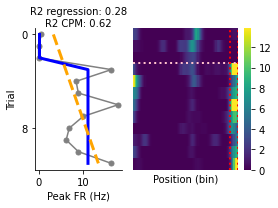

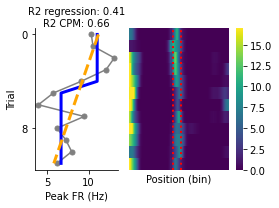

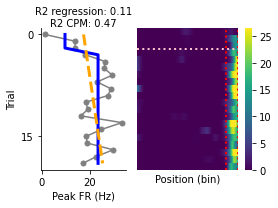

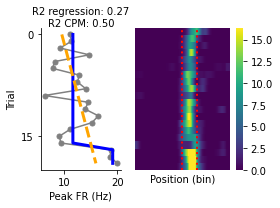

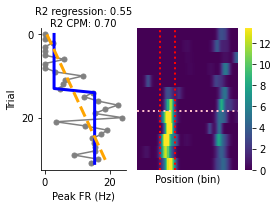

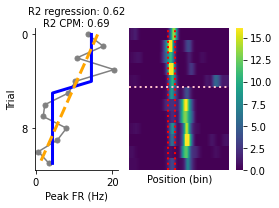

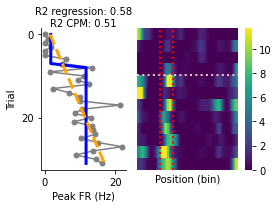

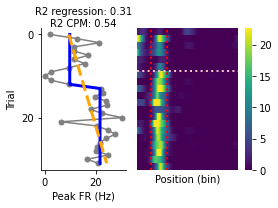

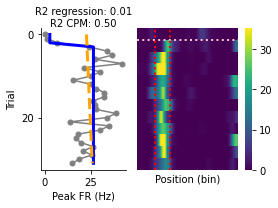

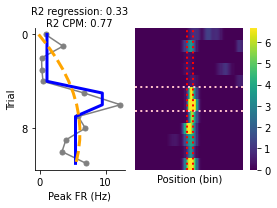

In [66]:
dosave = False
all_fields_recombined = all_fields_recombined_all.loc[ani,sess]
all_fields_row_one=all_fields_recombined.loc[ta,tt,uid,field_id]

fr_map_trial_df=fr_map_trial_df_all.loc[(ani,sess),:].dropna(axis=1,how='all')
X_raw = X_raw_all.loc[(ani,sess),:]
X_pwc=X_pwc_all.loc[(ani,sess),:]
all_sw_d=all_sw_d_all.loc[(ani,sess),:]
trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df_all.loc[(ani,sess),:])


for (tt,uid,field_id,order) in tt_uid_field_id_order_l:
    fig,axs=svga.fit_plot_step_vs_continuous_example(fr_map_trial_df,
                                            X_raw,X_pwc,all_sw_d,trial_index_to_index_within_df,
                                            all_fields_recombined,
                                            best_n_one,
                                            ncpts=order,ii=None,
                                            ta=ta,tt=tt,min_size=2,
                                                uid=uid,field_id=field_id,
                                                     dosave=dosave,
                                                     figdir=figdir,
                                                     sess=sess,
                                                     figsize=(4,3),
                                                     do_legend=False,
                                           )
    
#     axs[0].legend([]).remove()

In [18]:

# initialize the holder of example indices
tt_uid_field_id_order_l = []

# selecting one ON
ta=0
tt=0
best_n_one = best_n_all_test.loc[ani,sess,ta,tt]
ma=best_n_one==1
ii=0
uid,field_id = best_n_one.index[ma][ii]

tt_uid_field_id_order_l.append((tt,uid,field_id,1))


/tmp/ipykernel_1777545/3236503568.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_n_one = best_n_all_test.loc[ani,sess,ta,tt]


In [19]:
# selecting first on then off
si_thresh = 0.5
gpb=all_sw_with_metrics_one.groupby(['trialtype','uid','field_index'])
uid_satisfying_cond = []
for k,val in gpb:
    cond = ((val['switch']==1).sum()==1) & ((val['switch']==-1).sum()==1) & (val['si'].mean() > si_thresh)
    if cond:
        if val.query('switch==1')['trial_index'].iloc[0] < val.query('switch==-1')['trial_index'].iloc[0]:
#             uid_satisfying_cond[k] = val
            uid_satisfying_cond.append(k)
tt,uid,field_id = uid_satisfying_cond[5]
tt_uid_field_id_order_l.append((tt,uid,field_id,2))


In [29]:
np.random.seed(0)
all_sw_with_metrics_one_si_thresh=all_sw_with_metrics_one.query('si>@si_thresh')
sub=all_sw_with_metrics_one_si_thresh.sample(50)

In [ ]:
### subselect has switch and si>si_thresh


In [30]:
best_n_one>0

31   1    0
32   1    1
34   0    0
35   1    0
36   0    0
         ..
370  1    0
     2    0
371  0    0
373  0    0
375  0    0
Length: 332, dtype: int64

/tmp/ipykernel_1777545/1626298969.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_recombined = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_1777545/1626298969.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df=fr_map_trial_df_all.loc[(ani,sess),:].dropna(axis=1,how='all')
/tmp/ipykernel_1777545/1626298969.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[(ani,sess),:]
/tmp/ipykernel_1777545/1626298969.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc=X_pwc_all.loc[(ani,sess),:]
/tmp/ipykernel_1777545/1626298969.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d=all_sw_d_all.loc[(ani,sess),:]
/tmp/ipykernel_1777545/1626298969.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  trial_index_to_index_within_df = dpp.trial_index_to_index_withi

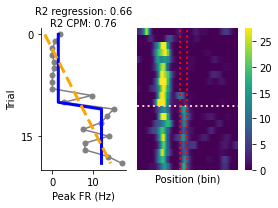

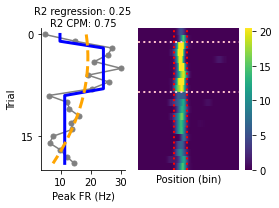

In [22]:
dosave = False
all_fields_recombined = all_fields_recombined_all.loc[ani,sess]
all_fields_row_one=all_fields_recombined.loc[ta,tt,uid,field_id]

fr_map_trial_df=fr_map_trial_df_all.loc[(ani,sess),:].dropna(axis=1,how='all')
X_raw = X_raw_all.loc[(ani,sess),:]
X_pwc=X_pwc_all.loc[(ani,sess),:]
all_sw_d=all_sw_d_all.loc[(ani,sess),:]
trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df_all.loc[(ani,sess),:])


for (tt,uid,field_id,order) in tt_uid_field_id_order_l:
    fig,axs=svga.fit_plot_step_vs_continuous_example(fr_map_trial_df,
                                            X_raw,X_pwc,all_sw_d,trial_index_to_index_within_df,
                                            all_fields_recombined,
                                            best_n_one,
                                            ncpts=order,ii=None,
                                            ta=ta,tt=tt,min_size=2,
                                                uid=uid,field_id=field_id,
                                                     dosave=dosave,
                                                     figdir=figdir,
                                                     sess=sess,
                                                     figsize=(4,3),
                                                     do_legend=False,
                                           )
    
#     axs[0].legend([]).remove()